<a href="https://colab.research.google.com/github/nv-hiep/dust_scattering/blob/main/Mie_vs_RG_scattering_with_MRN77_sizedist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cross-sections from the RG-Drude and Mie scatterings**

*   Step 1: Select a grain size distribution (MRN1977 or WD2001) and materials (Silicate or Graphite). **Here I used MRN1977**.
*   Step 2: Select Scattering models (Rayleigh-Gans RG, Mie) and Materials for cmi models (complex index of refraction models: Drude, Silicate, Graphite, SmallGraphite).
*   Step 3: Calculate Scattering Cross-Section, Scattering Opacity.
*   Step 4: Plot


# 1. Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls

Mounted at /content/gdrive


# 2. Root directory

In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks/dust'

/content/gdrive/My Drive/Colab Notebooks/dust


# 3. Import Libraries



## 3.1 Standard libraries

In [ ]:
import os
import numpy   as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline  

## 3.2 Dust libraries

In [ ]:
import libs.constants    as c

from libs                import sizedist
from libs.extinction     import scattools

## 4. Set some parameters: dust mass column, energy range, wavelength range

In [ ]:
NH     = 1.e21                                # H column density [H cm^-2]
D2G    = 0.009                                # Dust-to-gas ratio
M_dust = NH * c.M_p * D2G                     # Dust mass column [g cm^-2]

E_range    = np.logspace(-0.6, 1., 20)        # KeV, slow
lambda_    = c.HC / E_range                   # [cm]      
lambda_    = lambda_ / c.MICRON2CM            # [micron]
lambda_inv = 1. / lambda_                     # [um^-1]

# 5. Grain size distributions and materials

**Here I used MRN1977**.

See mie_vs_RG_scattering_with_WD01_sizedist.ipynb for WD2001 model

In [ ]:
rho_sil, rho_gra, rho_avg = 3.8, 2.2, 3.            # [g cm^-3] see Draine's ISM book

amin, amax = 0.005, 0.25                            # micron (limits on grain size distribution for MRN model)
pdist_MNR  = 3.5                                    # power law, p = 3.5

MRN_sil = sizedist.MRN77(amin=amin, amax=amax, p=pdist_MNR, rho=rho_sil, md=M_dust)
MRN_gra = sizedist.MRN77(amin=amin, amax=amax, p=pdist_MNR, rho=rho_gra, md=M_dust)
MRN_avg = sizedist.MRN77(amin=amin, amax=amax, p=pdist_MNR, rho=rho_avg, md=M_dust)

# 6. Grain scattering models

Select from:
*   Scattering models: RG, Mie
*   Materials for models odels of the complex index of refraction: Drude, Silicate, Graphite, SmallGraphite

In [ ]:
RG_Drude     = scattools.create_scat_model('RG','Drude')
Mie_sil      = scattools.create_scat_model('Mie','Silicate')
Mie_gra      = scattools.create_scat_model('Mie','Graphite')
Mie_smallgra = scattools.create_scat_model('Mie','SmallGraphite')

In [ ]:
print(RG_Drude.__dict__.keys())
print(type(RG_Drude.scat_model))
print(type(RG_Drude.cmindex_model))

dict_keys(['scat_model', 'cmindex_model', 'scat_type', 'cmindex_type'])
<class 'libs.extinction.scatmodels.RGscat'>
<class 'libs.composition.cmindex.CmDrude'>


# 7. Scattering cross-sections

<!-- $$\kappa = \frac{1}{M_d}\ \int \sigma\ \frac{dn}{da}\ da $$ -->

In [ ]:
%%time
RGD_kappa = scattools.KappaScat(E=E_range, dist=MRN_avg, scatm=RG_Drude)

CPU times: user 7.87 ms, sys: 914 µs, total: 8.79 ms
Wall time: 9.51 ms


In [ ]:
%%time
sil_kappa = scattools.KappaScat(E=E_range, dist=MRN_sil, scatm=Mie_sil)

CPU times: user 1min 43s, sys: 16.2 ms, total: 1min 43s
Wall time: 1min 43s


In [ ]:
%%time
gra_kappa = scattools.KappaScat(E=E_range, dist=MRN_gra, scatm=Mie_gra)

CPU times: user 3min 33s, sys: 87.9 ms, total: 3min 34s
Wall time: 3min 34s


# 8. Plot

M_dust : mass density of dust [in this case : g cm^-2]

nd     : number density of dust [in this case: cm^-2]

rho    : dust grain material density [g cm^-3]




$$\kappa = \frac{1}{M_{dust}}\ \int \sigma_{sca}\ \frac{dn}{da}\ da $$

$$\kappa = \pi a^2 Q_{sca} N_{dust} / M_{dust} = \sigma_{sca} * N_{dust} / M_{dust}$$

$$\kappa = \tau_{sca}/M_{dust}$$

$$M_{dust} = N_H * m_p * d2g$$

Multiply <code>kappa</code> by the dust mass to get the total opacity.

In [ ]:
def plot_(ax, obj, **kwargs):

  tau_sca = obj.kappa * obj.dist.md
  ax.plot(obj.E, tau_sca, **kwargs)

  ax.tick_params(labelsize=15)
  ax.set_xlabel('Energy (keV)', size=15)
  ax.set_ylabel(r'Scattering Opacity ($\tau$ per 10$^{21}$ H cm$^{-2}$)', size=15)

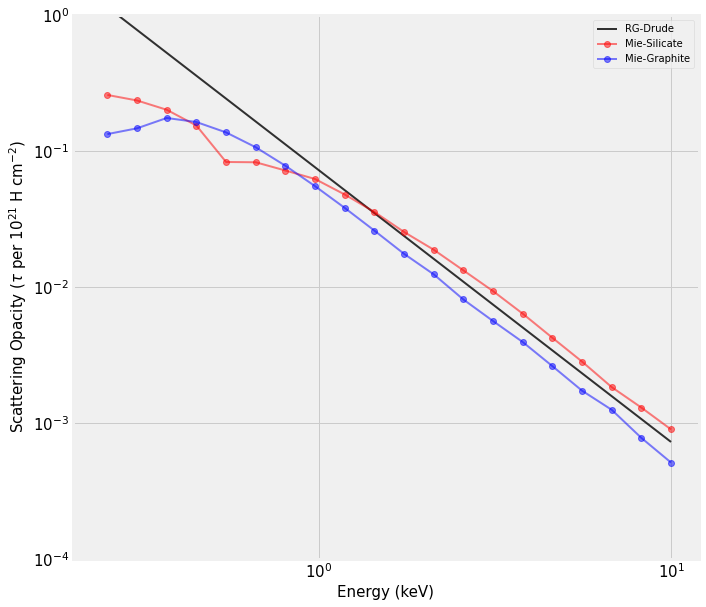

In [ ]:
plt.figure( figsize=(10, 10) )
ax = plt.subplot(111)

plot_(ax, RGD_kappa, color='k', lw=2, alpha=0.8, label='RG-Drude')
plot_(ax, sil_kappa, marker='o', color='r', lw=2, alpha=0.5, label='Mie-Silicate')
plot_(ax, gra_kappa, marker='o', color='b', lw=2, alpha=0.5, label='Mie-Graphite')
plt.legend(loc='upper right', frameon=False)
plt.loglog()

plt.xlim(0.2, 12.)
plt.ylim(1.e-4, 1.)

plt.legend()
plt.show()